# 4. Rate prediction for the final year

The aim of this notebook is to use the best model and sampling rate found in the previous notebooks to predict the arrival rates for an entire year. We train our model on our training dataset, then predict the 52 weeks of 2019 using the 52 weeks of 2018. This predicted data will then be used in the discretization notebook to generate discrete arrival times.

## Setup and data loading

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

from utils import *
%load_ext autoreload
%autoreload 2

2021-12-23 01:21:03.507028: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-23 01:21:03.507060: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-12-23 01:21:05.912962: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-23 01:21:05.912988: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-23 01:21:05.913012: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (luca-Surface-Pro-6): /proc/driver/nvidia/version does not exist
2021-12-23 01:21:05.913200: I tensorflow/core/platform/cpu

In [2]:
DATA_PATH = '../data/405.txt'
OUTPUT_PATH = '../data/predictions.csv'

cols_map = {
    "DTS": "crossTime",
    #"LANE": "lane",
    #"DIR": "direction",
    "SPEED": "speed",
    # "AX": "nAxles",
    "GW_TOT": "weight",
    # "TYPE": "type",
}

data = pd.read_csv(DATA_PATH, usecols=cols_map.keys())
data.rename(columns=cols_map, inplace=True)
# Parse crossTime column as datetime object
data.crossTime = pd.to_datetime(data.crossTime+'0000', format='%Y-%m-%d %H:%M:%S.%f')
data.head(2)

,crossTime,speed,weight
0,2011-04-01 00:41:31.400,106,15980
1,2011-04-01 00:42:10.500,116,3630


## Feature engineering

We take the raw data and transform it using the pipeline defined in notebook 2.

In [3]:
def pipeline(sampling_interval):
    
    # Index by crossing time
    feature_cols = [col for col in data.columns if col != 'crossTime']
    features = data[feature_cols]
    features.index = data.crossTime
            
    # Truncate data to have ignore COVID pandemic 
    start_of_covid = "2019-10-21"
    features = features.truncate(after=start_of_covid)

    # Downsample and add vehicle counts
    resampled = features.resample(sampling_interval)
    features = resampled.sum()
    features['n_vehicles'] = resampled.size()
        
    ## FEATURE ENGINEERING
    
    # HGV movement restrictions 
    legal_driving_start = 5
    legal_driving_end = 22
    legal_driving_duration = legal_driving_end - legal_driving_start
    sunday = 6
    
    dayofweek = pd.Series(features.index.dayofweek, index=features.index)
    hours = pd.Series(features.index.hour, index=features.index)
    shifted_hours = hours - legal_driving_start
    
    features['is_legal'] = (((0 <= shifted_hours) & (shifted_hours < legal_driving_duration))).astype(int)
    
    # Time periodicity features
    minute_s = 60
    hour_s = minute_s * 60
    day_s = 24 * hour_s # 24h x 60m x 60s
    week_s = 7 * day_s
    year_s = 365.2425 * day_s
    
    features = add_time_period_cols(features, day_s, 'day')
    features = add_time_period_cols(features, week_s, 'week')
    features = add_time_period_cols(features, year_s, 'year')    
    
    # Split data giving 2y to test and val each, then normalize data with training set
    return split_norm_data(features, return_mean_std=True, splitter=year_splitter)

In [4]:
train, val, test, train_mean, train_std = pipeline('1h')
labels = ['n_vehicles', 'speed', 'weight']

## Model prediction

### Windowing 

We define the same time window as in notebook 2, using the best samping interval (1h) defined in notebook 3

In [17]:
WEEK_STEPS = 7 * 24
YEAR_STEPS = 52 * WEEK_STEPS
SHIFT_STEPS = YEAR_STEPS      # predict same week of following year

week_window = make_window(train, val, test, train_mean, train_std,
                          input_w=WEEK_STEPS, label_w=WEEK_STEPS,
                          shift=SHIFT_STEPS, label_cols=labels)
week_window

Total window size: 8904
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167]
Label indices: [8736 8737 8738 8739 8740 8741 8742 8743 8744 8745 8746 8747 8748 8749
 8750 8751 8752 8753 8754 8755 8756 8757 8758 8759 8760 8761 8762 8763
 8764 8765 8766 8767 8768 8769 8770 8771 8772 8773 8774 8775 8776 8777
 8778 8779 8780 8781 8782 8783 8784 8785 8786 8787

### Model creation

We create the same model as in notebook 2

In [6]:
rnn = lstm_model(len(labels))
history = compile_and_fit(rnn, week_window)

Epoch 1/20
346/346 [==============================] - 26s 71ms/step - loss: 0.6118 - mean_squared_error: 0.6118 - mean_absolute_error: 0.5714 - val_loss: 0.4137 - val_mean_squared_error: 0.4137 - val_mean_absolute_error: 0.4513
Epoch 2/20
346/346 [==============================] - 24s 69ms/step - loss: 0.3421 - mean_squared_error: 0.3421 - mean_absolute_error: 0.3949 - val_loss: 0.3463 - val_mean_squared_error: 0.3463 - val_mean_absolute_error: 0.3814
Epoch 3/20
346/346 [==============================] - 24s 69ms/step - loss: 0.2860 - mean_squared_error: 0.2860 - mean_absolute_error: 0.3430 - val_loss: 0.3148 - val_mean_squared_error: 0.3148 - val_mean_absolute_error: 0.3434
Epoch 4/20
346/346 [==============================] - 24s 69ms/step - loss: 0.2614 - mean_squared_error: 0.2614 - mean_absolute_error: 0.3168 - val_loss: 0.3135 - val_mean_squared_error: 0.3135 - val_mean_absolute_error: 0.3347
Epoch 5/20
346/346 [==============================] - 24s 68ms/step - loss: 0.2561 - mea

We plot our model predictions on the training data set as an illustration

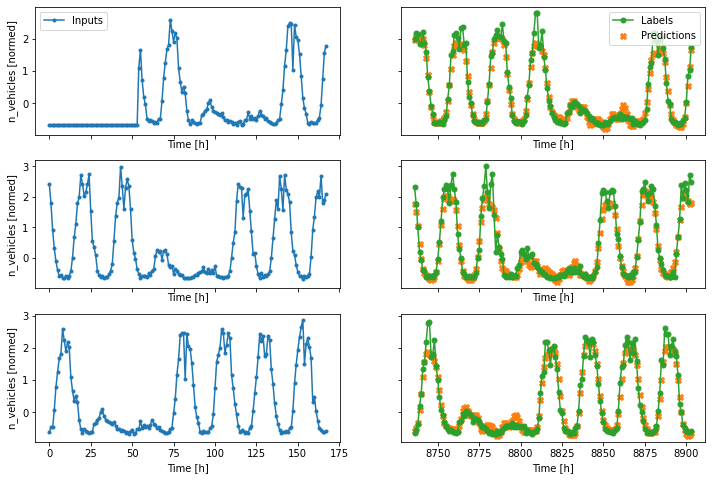

In [18]:
fig = week_window.plot(rnn)
plt.show()

### Prediction dataset

We now need to generate the final dataset that will be used in the next phase. We do so by splitting our test data in two, the input year (2018) and the output year (2019).

In [19]:
# Make TF dataset w/o shuffling, w/o zero-week-filtering, and where 
# 1 batch = 52 (in week, out week) pairs 
test_tf = week_window.make_dataset(test, training=False)
test_in, test_out = next(iter(test_tf)) # Extract single batch from tf dataset

Sanity check: check that the tensorflow batches correspond to the correct weeks

In [20]:
for i, (in_tf, out_tf) in enumerate(zip(test_in, test_out)):        
    # Extracts input weeks from TF and corresponding consecutive weeks in pandas
    inputs = pd.DataFrame(in_tf.numpy(), columns=test.columns)
    pd_inputs = test.iloc[week_window.input_indices + i * week_window.input_width]
    pd_inputs = pd_inputs.reset_index().drop(columns='crossTime').astype('float32')
    
    # Same for outputs
    outputs = pd.DataFrame(out_tf.numpy(), columns=labels)
    pd_outputs = test.iloc[week_window.label_indices + i * week_window.input_width][labels]
    pd_outputs = pd_outputs.reset_index().drop(columns='crossTime').astype('float32')

    # Throw exception if not
    pd.testing.assert_frame_equal(outputs, pd_outputs)
    pd.testing.assert_frame_equal(outputs, pd_outputs)

We make our predictions to get a (week, hour of week, feature) tensor

In [21]:
predictions = rnn(test_in)
weeks, hours, features = predictions.shape

predictions.shape

TensorShape([52, 168, 3])

We reshape it to get a (hour of year, features) tensor and convert it to a pandas time series.

In [22]:
predictions = tf.reshape(predictions, (weeks*hours, features)).numpy()
predictions.shape

(8736, 3)

In [23]:
test.iloc[week_window.label_start:-1].index

DatetimeIndex(['2018-10-21 23:00:00', '2018-10-22 00:00:00',
               '2018-10-22 01:00:00', '2018-10-22 02:00:00',
               '2018-10-22 03:00:00', '2018-10-22 04:00:00',
               '2018-10-22 05:00:00', '2018-10-22 06:00:00',
               '2018-10-22 07:00:00', '2018-10-22 08:00:00',
               ...
               '2019-10-20 13:00:00', '2019-10-20 14:00:00',
               '2019-10-20 15:00:00', '2019-10-20 16:00:00',
               '2019-10-20 17:00:00', '2019-10-20 18:00:00',
               '2019-10-20 19:00:00', '2019-10-20 20:00:00',
               '2019-10-20 21:00:00', '2019-10-20 22:00:00'],
              dtype='datetime64[ns]', name='crossTime', length=8736, freq='H')

In [24]:
index = test.iloc[week_window.label_start:-1].index
predictions = pd.DataFrame(predictions, columns=labels, index=index)

In [25]:
predictions

,n_vehicles,speed,weight
crossTime,,,
2018-10-21 23:00:00,-0.489543,-0.490554,-0.463437
2018-10-22 00:00:00,-0.554645,-0.557885,-0.537572
2018-10-22 01:00:00,-0.616780,-0.620239,-0.605116
2018-10-22 02:00:00,-0.640233,-0.639383,-0.624427
2018-10-22 03:00:00,-0.583288,-0.582199,-0.572487
...,...,...,...
2019-10-20 18:00:00,-0.522143,-0.510097,-0.565657
2019-10-20 19:00:00,-0.546635,-0.527359,-0.569394
2019-10-20 20:00:00,-0.521490,-0.504879,-0.526048


We still need to rescale the dataset, but it is almost ready to be used.

## Performance evaluation and data generation

### Evaluating performance

We breifly compute the MSE and MAE error between our predictions and our targets. We still take zero weeks into account, to see better evaluation results, consult notebook 2.

In [35]:
_, mse, mae = rnn.evaluate(test_tf)

print(f"\nWe get a mean squared error of {mse:.4f} on our predicted dataset")
print(f"We get a mean absolute error of {mae:.4f} on our predicted dataset")

1/1 [==============================] - 0s 89ms/step - loss: 0.2964 - mean_squared_error: 0.2964 - mean_absolute_error: 0.3301

We get a mean squared error of 0.2964 on our predicted dataset
We get a mean absolute error of 0.3301 on our predicted dataset


This is similar to the performance found in earlier notebooks

### Generating data

We remove the standard scaling that was applied in our feature engineering pipeline to obtain a interpretable dataset. We save this predictions dataset to disk.

In [43]:
def denormalize(data, mean=train_mean, std=train_std):
    data = data.copy()
    data = data * std[labels] + mean[labels]
    
    data['n_vehicles'] = data['n_vehicles'].round()
    
    return data

In [44]:
de_predictions = denormalize(predictions)

In [45]:
de_predictions.to_csv(OUTPUT_PATH)
de_predictions

,n_vehicles,speed,weight
crossTime,,,
2018-10-21 23:00:00,13.0,1116.889623,216054.202870
2018-10-22 00:00:00,9.0,731.708958,131706.253045
2018-10-22 01:00:00,4.0,374.993531,54856.505338
2018-10-22 02:00:00,3.0,265.473995,32885.813193
2018-10-22 03:00:00,7.0,592.614448,91980.460638
...,...,...,...
2019-10-20 18:00:00,11.0,1005.091456,99752.063848
2019-10-20 19:00:00,9.0,906.338514,95499.715573
2019-10-20 20:00:00,11.0,1034.943991,144818.315785


### Plotting results

As an illustration, we plot our predicted columns versus the first 15 days of Febuary

In [63]:
def plot_week(predictions, start, end, test=test):
    fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

    te = denormalize(test)
    
    for i, (col, ax) in enumerate(zip(labels, axs.flatten())):
        ax.set_title(col)
        ax.set_xlabel('Day of crossing [days]')
    
        te = te.loc[start:end]
        pred = predictions.loc[start:end]
                
        te[col].plot(ax=ax, label='actual')
        pred[col].plot(ax=ax, label='predicted')

        if i == 0:
            ax.legend()    

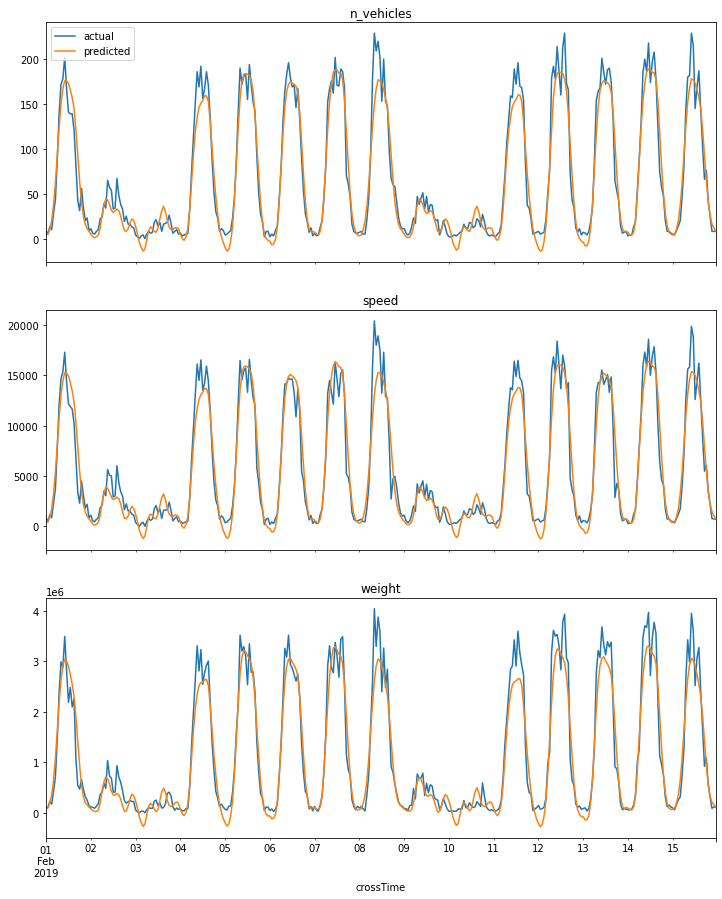

<Figure size 576x432 with 0 Axes>

In [69]:
plot_week(de_predictions, start="Feb 1st 2019", end="Feb 15th 2019")
plt.show()
plt.clf()